# "NMT by Jointly Learning to Align and Translate" Implementation

original paper: https://arxiv.org/abs/1409.0473

references
* arichitecture picture: https://arxiv.org/pdf/1703.03906.pdf
* tutorial: https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb
* data source: http://www.statmt.org/wmt14/translation-task.html
* data source2: http://www.manythings.org/anki/

In [38]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, Iterator, BucketIterator, TabularDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# others
import unicodedata
import re
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [39]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.cuda.current_device()
# USE_CUDA = False
# DEVICE = -1

## Prepare data

In [40]:
# train_path = 'data/en_de/en_de_1000.txt' # cannot use because of gpu memory is not enough
train_file = 'eng-fra-filtered.train'
valid_file = 'eng-fra-filtered.valid'
test_file = 'eng-fra-filtered.test'
BATCH_SIZE = 64

In [41]:
SOURCE = Field(tokenize=str.split, use_vocab=True, init_token="<s>", eos_token="</s>", lower=True, 
               include_lengths=True, batch_first=True)
TARGET = Field(tokenize=str.split, use_vocab=True, init_token="<s>", eos_token="</s>", lower=True, 
               batch_first=True)

In [43]:
train_data, valid_data, test_data = \
    TabularDataset.splits(path='data/en_fa/', format='tsv', train=train_file, validation=valid_file, test=test_file,
                          fields=[('so', SOURCE), ('ta', TARGET)])

In [44]:
SOURCE.build_vocab(train_data)
TARGET.build_vocab(train_data)

In [46]:
train_loader = BucketIterator(train_data, batch_size=BATCH_SIZE, device=DEVICE,
                              sort_key=lambda x: len(x.so), sort_within_batch=True, repeat=False)
train_loader = BucketIterator(valid_data, batch_size=BATCH_SIZE, device=DEVICE,
                              sort_key=lambda x: len(x.so), sort_within_batch=True, repeat=False)
train_loader = BucketIterator(test_data, batch_size=BATCH_SIZE, device=DEVICE,
                              sort_key=lambda x: len(x.so), sort_within_batch=True, repeat=False)

In [47]:
len(SOURCE.vocab), len(TARGET.vocab)

(5229, 9075)

## architecture

![](./pics/encoder_decoder_att.png)

## Encoder

In [33]:
class Encoder(nn.Module):
    def __init__(self, V_e, m_e, n_e, num_layers=1, bidrec=False):
        super(Encoder, self).__init__()
        """
        vocab_size: V_e
        embed_size: m_e
        hidden_size: n_e
        """
        self.V_e = V_e
        self.m_e = m_e
        self.n_e = n_e
        self.num_layers = num_layers
        self.bidrec = bidrec
        self.n_direct = 2 if bidrec else 1
        
        self.embed = nn.Embedding(V_e, m_e) 
        self.gru = nn.GRU(m_e, n_e, num_layers, batch_first=True, bidirectional=bidrec)
        
    def forward(self, inputs, lengths):
        """
        input: 
        - inputs: B, T_x
        - lengths: actual max length of batches
        output:
        - outputs: B, T_x, n_e
        """
        # embeded: (B, T_x, n_e)
        embeded = self.embed(inputs) 
        # packed: (B*T_x, n_e)
        packed = pack_padded_sequence(embeded, lengths, batch_first=True) 
        # packed outputs: (B*T_x, 2*n_e)
        # hidden: (num of layers*n_direct, B, 2*n_e)
        outputs, hidden = self.gru(packed)
        # unpacked outputs: (B, T_x, 2*n_e)
        outputs, output_lengths = pad_packed_sequence(outputs, batch_first=True)
        
        # hidden bidirection: (num of layers*n_direct(0,1,2...last one), B, n_e)
        # choosen last hidden: (B, 1, 2*n_e)
        hidden = torch.cat([h for h in hidden[-self.n_direct:]], 1).unsqueeze(1)
        
        return outputs, hidden

## Attention

In [34]:
class Attention(nn.Module):
    def __init__(self, hidden_size, hidden_size2=None, method='general'):
        super(Attention, self).__init__()
        """
        hidden_size: set hidden size same as decoder hidden size which is n_d (= 2*n_e)
        hidden_size2: only for concat&paper method, if none then is same as hidden_size (n_d)
        (in paper notation is n', https://arxiv.org/abs/1409.0473)
        methods:
        - 'dot': dot product between hidden and encoder_outputs
        - 'general': encoder_outputs through a linear layer 
        - 'concat': concat (hidden, encoder_outputs)
        - 'paper': concat + tanh
        """
        self.method = method
        self.hidden_size = hidden_size 
        self.hidden_size2 = hidden_size2 if hidden_size2 else hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size) 
            # linear_weight shape: (out_f, in_f)
            # linear input: (B, *, in_f)
            # linear output: (B, *, out_f)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size*2, self.hidden_size2)
            self.v = nn.Parameter(torch.FloatTensor(1, self.hidden_size2))
        
        
    def forward(self, hidden, encoder_outputs, encoder_lengths=None, return_weight=False):
        """
        input:
        - hidden, previous hidden(= H): B, 1, n_d 
        - encoder_outputs, source context(= O): B, T_x, n_d
        - encoder_lengths: real lengths of encoder outputs
        - return_weight = return weights(alphas)
        output:
        - attentioned_hidden(= z): B, 1, n_d
        - weights(= w): B, 1, T_x
        """
        H, O = hidden, encoder_outputs
        # Batch(B), Seq_length(T), dimemsion(n)
        B_H, T_H, n_H = H.size()
        B_O, T_O, n_O = O.size()
        
        if B_H != B_O:
            msg = "Batch size is not correct, H: {} O: {}".format(H.size(), O.size())
            raise ValueError(msg)
        else:
            B = B_H
        
        # score: (B, 1, T_x)
        s = self.score(H, O) 
        
        # encoding masking: ensure not to calculate paddings
        if encoder_lengths is not None:
            mask = s.data.new(B, T_H, T_O) # (B, 1, T_x)
            mask = self.fill_context_mask(mask, sizes=encoder_lengths, v_mask=float('-inf'), v_unmask=0)
            s += mask
        
        # softmax: (B, 1, T_x)
        w = F.softmax(s, 2) 
        
        # attention: weight * encoder_hiddens, (B, 1, T_x) * (B, T_x, n_d) = (B, 1, n_d)
        z = w.bmm(O)
        if return_weight:
            return z, w
        return z
    
    def score(self, H, O):
        """
        inputs:
        - hiddden, previous hidden(= H): B, 1, n_d 
        - encoder_outputs, source context(= O): B, T_x, n_d
        """
        if self.method == 'dot':
            # bmm: (B, 1, n_d) * (B, n_d, T_x) = (B, 1, T_x)
            e = H.bmm(O.transpose(1, 2))
            return e
        
        elif self.method == 'general':
            # attn: (B, T_x, n_d) > (B, T_x, n_d)
            # bmm: (B, 1, n_d) * (B, n_d, T_x) = (B, 1, T_x)
            e = self.attn(O)
            e = H.bmm(e.transpose(1, 2))
            return e
        
        elif self.method == 'concat':
            # H repeat: (B, 1, n_d) > (B, T_x, n_d)
            # cat: (B, T_x, 2*n_d)
            # attn: (B, T_x, 2*n_d) > (B, T_x, n_d)
            # v repeat: (1, n_d) > (B, 1, n_d)
            # bmm: (B, 1, n_d) * (B, n_d, T_x) = (B, 1, T_x)
            cat = torch.cat([H.repeat(1, O.size(1), 1), O], 2)
            e = self.attn(cat)
            v = self.v.repeat(O.size(0), 1).unsqueeze(1)
            e = v.bmm(e.transpose(1, 2))
            return e
        
        elif self.method == 'paper':
            # add tanh after attention linear layer in 'concat' method
            cat = torch.cat([H.repeat(1, O.size(1), 1), O], 2)
            e = F.tanh(self.attn(cat))
            v = self.v.repeat(O.size(0), 1).unsqueeze(1)
            e = v.bmm(e.transpose(1, 2))
            return e
    
    def fill_context_mask(self, mask, sizes, v_mask, v_unmask):
        """Fill attention mask inplace for a variable length context.
        Args
        ----
        mask: Tensor of size (B, T, D)
            Tensor to fill with mask values. 
        sizes: list[int]
            List giving the size of the context for each item in
            the batch. Positions beyond each size will be masked.
        v_mask: float
            Value to use for masked positions.
        v_unmask: float
            Value to use for unmasked positions.
        Returns
        -------
        mask:
            Filled with values in {v_mask, v_unmask}
        """
        mask.fill_(v_unmask)
        n_context = mask.size(2)
        for i, size in enumerate(sizes):
            if size < n_context:
                mask[i,:,size:] = v_mask
        return mask

## Decoder

In [43]:
class Decoder(nn.Module):
    def __init__(self, V_d, m_d, n_d, sos_idx, num_layers=1, hidden_size2=None, method='general', 
                 return_weight=True, max_len=15):
        super(Decoder, self).__init__()
        """
        vocab_size: V_d
        embed_size: m_d
        hidden_size: n_d (set this value as 2*n_e)
        methods:
        - 'dot': dot product between hidden and encoder_outputs
        - 'general': encoder_outputs through a linear layer 
        - 'concat': concat (hidden, encoder_outputs)
        - 'paper': concat + tanh
        return_weight: return attention weights
        """
        self.V_d = V_d
        self.m_d = m_d
        self.n_d = n_d
        self.sos_idx = sos_idx
        self.num_layers = num_layers
        self.return_weight = return_weight
        self.method = method
        # attention
        self.attention = Attention(hidden_size=n_d, hidden_size2=hidden_size2, method=method)
        # embed
        self.embed = nn.Embedding(V_d, m_d)
        # gru(W*[embed, context] + U*[hidden_prev])
        # gru: m+n
        self.gru = nn.GRU(m_d+n_d, n_d, num_layers, batch_first=True, bidirectional=False) 
        # linear
        self.linear = nn.Linear(2*n_d, V_d)
        self.max_len = max_len
        
        
    def start_token(self, batch_size):
        sos = torch.LongTensor([self.sos_idx]*batch_size).unsqueeze(1)
        if USE_CUDA: sos = sos.cuda()
        return sos
    
    def forward(self, hidden, enc_outputs, enc_outputs_lengths=None, max_len=None):
        """
        input:
        - hidden(previous hidden): B, 1, n_d 
        - enc_outputs(source context): B, T_x, n_d
        - enc_outputs_lengths: list type
        - max_len(targer sentences max len in batch): T_y
        """
        if max_len is None: max_len = self.max_len
        
        inputs = self.start_token(hidden.size(0)) # (B, 1)
        embeded = self.embed(inputs) # (B, 1, m_d)
        # prepare for whole targer sentence scores
        scores = []
        attn_weights = []
        
        for i in range(max_len):
            # context vector: previous hidden(s{i-1}), encoder_outputs(O_e) > context(c{i}), weights
            # - context: (B, 1, n_d)
            # - weights: (B, 1, T_x)
            context, weights = self.attention(hidden, enc_outputs, enc_outputs_lengths, 
                                              return_weight=self.return_weight)
            attn_weights.append(weights.squeeze(1))
            
            # concat context & embedding vectors: (B, 1, m_d+n_d)
            gru_input = torch.cat([embeded, context], 2)
            
            # gru((context&embedding), previous hidden)
            # output hidden(s{i}): (1, B, n_d)
            _, hidden = self.gru(gru_input, hidden.transpose(0, 1))
            hidden = hidden.transpose(0, 1) # change shape to (B, 1, n_d) again
            
            # concat context and new hidden vectors: (B, 1, 2*n_d)
            concated = torch.cat([hidden, context], 2)
            
            # get score: (B, V_d)
            score = self.linear(concated.squeeze(1))
            scores.append(score)
            
            # greedy method
            decoded = score.max(1)[1]  # (B)
            embeded = self.embed(decoded).unsqueeze(1) # next input y{i-1} (B, 1, m_d) 

        # column-wise concat, reshape!! 
        # scores = [(B, V_d), (B, V_d), (B, V_d)...] > (B, V_d*max_len)
        # attn_weights = [(B, T_x), (B, T_x), (B, T_x)...] > (B*max_len, T_x)
        scores = torch.cat(scores, 1)
        return scores.view(inputs.size(0)*max_len, -1), torch.cat(attn_weights)

## Parameters

In [44]:
V_so = len(SOURCE.vocab)
V_ta = len(TARGET.vocab)
HIDDEN = 500
EMBED = 100
STEP = 200
LR = 0.001
NUM_LAYERS = 1
BATCH_SIZE = BATCH_SIZE

---

## Build Networks

In [37]:
enc = Encoder(V_so, EMBED, HIDDEN, NUM_LAYERS, bidrec=True)
dec = Decoder(V_ta, EMBED, 2*HIDDEN, sos_idx=SOURCE.vocab.stoi['<s>'], method='general')
if USE_CUDA:
    enc = enc.cuda()
    dec = dec.cuda()

loss_function = nn.CrossEntropyLoss(ignore_index=TARGET.vocab.stoi['<pad>'])
optimizer = optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=LR)
scheduler = optim.lr_scheduler.MultiStepLR(gamma=0.1, milestones=[100], optimizer=optimizer)

## Train

In [38]:
enc.train()
dec.train()
for step in range(STEP):
    losses=[]
    scheduler.step()
    for i, batch in enumerate(train_loader):
        inputs, lengths = batch.so
        targets = batch.ta
        
        enc.zero_grad()
        dec.zero_grad()
        
        output, hidden = enc(inputs, lengths.tolist())
        preds, _ = dec(hidden, output, lengths.tolist(), targets.size(1)) # max_len
        
        loss = loss_function(preds, targets.view(-1))
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
    
    if step % 10 == 0:
        msg = '[{}/{}] train_loss: {:.4f}, lr: {}'.format(\
          step+1, STEP, np.mean(losses), round(scheduler.get_lr()[0], 6))
        print(msg)
        losses = []

[1/200] train_loss: 3.0524, lr: 0.001
[11/200] train_loss: 0.6400, lr: 0.001
[21/200] train_loss: 0.5111, lr: 0.001
[31/200] train_loss: 0.4594, lr: 0.001
[41/200] train_loss: 0.4230, lr: 0.001
[51/200] train_loss: 0.4023, lr: 0.001
[61/200] train_loss: 0.3802, lr: 0.001
[71/200] train_loss: 0.3608, lr: 0.001
[81/200] train_loss: 0.3556, lr: 0.001
[91/200] train_loss: 0.3464, lr: 0.001
[101/200] train_loss: 0.2895, lr: 0.0001
[111/200] train_loss: 0.2172, lr: 0.0001
[121/200] train_loss: 0.2101, lr: 0.0001
[131/200] train_loss: 0.2085, lr: 0.0001
[141/200] train_loss: 0.2064, lr: 0.0001
[151/200] train_loss: 0.2059, lr: 0.0001
[161/200] train_loss: 0.2048, lr: 0.0001
[171/200] train_loss: 0.2046, lr: 0.0001
[181/200] train_loss: 0.2042, lr: 0.0001
[191/200] train_loss: 0.2029, lr: 0.0001


In [39]:
torch.save(enc.state_dict(), './data/model/fra_eng.enc')
torch.save(dec.state_dict(), './data/model/fra_eng.dec')

## Load

In [48]:
enc = Encoder(V_so, EMBED, HIDDEN, NUM_LAYERS, bidrec=True)
dec = Decoder(V_ta, EMBED, 2*HIDDEN, sos_idx=SOURCE.vocab.stoi['<s>'], method='general')
if USE_CUDA:
    enc = enc.cuda()
    dec = dec.cuda()
    
enc.load_state_dict(torch.load('./data/model/fra_eng.enc'))
dec.load_state_dict(torch.load('./data/model/fra_eng.dec'))

## Test & Visualize Attention

In [49]:
# borrowed code from https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation-batched.ipynb

def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     show_plot_visdom()
    plt.show()
    plt.close()

In [50]:
def print_sentence(x):
    return [i for i in x if i not in ['<s>', '</s>']]

Source :  everything is normal .
Truth :  tout est normal .
Prediction :  tout est normal .


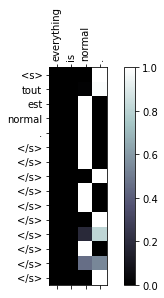

In [55]:
enc.eval()
dec.eval()

test = random.choice(train_data)
source_sentence = test.so
target_sentence = test.ta

s = torch.LongTensor(list(map(lambda x: SOURCE.vocab.stoi[x], source_sentence))).view(1, -1)
t = torch.LongTensor(list(map(lambda x: TARGET.vocab.stoi[x], target_sentence))).view(1, -1)
if USE_CUDA:
    s = s.cuda()
    t = t.cuda()

output, hidden = enc(s, [s.size(1)])
pred, attn = dec(hidden, output)
pred_sentence = [TARGET.vocab.itos[i] for i in pred.max(1)[1]]


print('Source : ', ' '.join(print_sentence(source_sentence)))
print('Truth : ', ' '.join(print_sentence(target_sentence)))
print('Prediction : ', ' '.join(print_sentence(pred_sentence)))

if USE_CUDA:
    attn = attn.cpu()

show_attention(source_sentence, pred_sentence, attn.data)